In [17]:
import pandas as pd

df = pd.read_csv("../output/preprocessed_data.csv")
df.head(1)

,id,company_description,source,is_edited,created_at,char_count,word_count,cleaned_description,cleaned_doc,stopword_ratio,...,url_list,has_url,email_list,has_email,money_list,has_money,date_list,has_date,masked_description,lemmatized_description
0,370341,Cegid is a leading provider of cloud business ...,linkedin,0,2023-08-05 12:22:59,1104,156,Cegid is a leading provider of cloud business ...,Cegid is a leading provider of cloud business ...,0.269231,...,"['www.cegid.com', 'http://jobs.cegid.com']",True,[],False,['791 millionmillion'],True,"['20', '20']",True,cegid is a leading provider of cloud business ...,cegid be a lead provider of cloud business man...


In [18]:
def inspect_random_description(df):
    """
    Inspect a random description from the DataFrame.
    """
    sample = df.sample(1)
    print("Original Description:")
    print(sample["company_description"].values[0])
    print("\nCleaned Description:")
    print(sample["cleaned_description"].values[0])
    print("\nMasked Description:")
    print(sample["masked_description"].values[0])
    print("\nLemmatized Description:")
    print(sample["lemmatized_description"].values[0])

In [19]:
inspect_random_description(df)

Original Description:
UK plastic packaging manufacturers, specialising in custom packaging designs, thermoforming, vaccum forming, butt fusion, sheet extrusion, foam inserts & more.

Cleaned Description:
UK plastic packaging manufacturers, specialising in custom packaging designs, thermoforming, vaccum forming, butt fusion, sheet extrusion, foam inserts & more.

Masked Description:
uk plastic packaging manufacturers, specialising in custom packaging designs, thermoforming, vaccum forming, butt fusion, sheet extrusion, foam inserts & more.

Lemmatized Description:
uk plastic packaging manufacturer specialise in custom packaging design thermoforme vaccum forming butt fusion sheet extrusion foam insert more


In [20]:
inspect_random_description(df)

Original Description:
Control your data. Collect your money. Exploration Group increases the value of your music copyrights through world-class administration. Get started today.

Cleaned Description:
Control your data. Collect your money. Exploration Group increases the value of your music copyrights through world-class administration. Get started today.

Masked Description:
control your data. collect your money. exploration group increases the value of your music copyrights through world-class administration. get started today.

Lemmatized Description:
control your datum collect your money exploration group increase the value of your music copyright through world class administration get start today


Generally looks like it's working as expected and terms are getting masked well, but with more time would investigate further

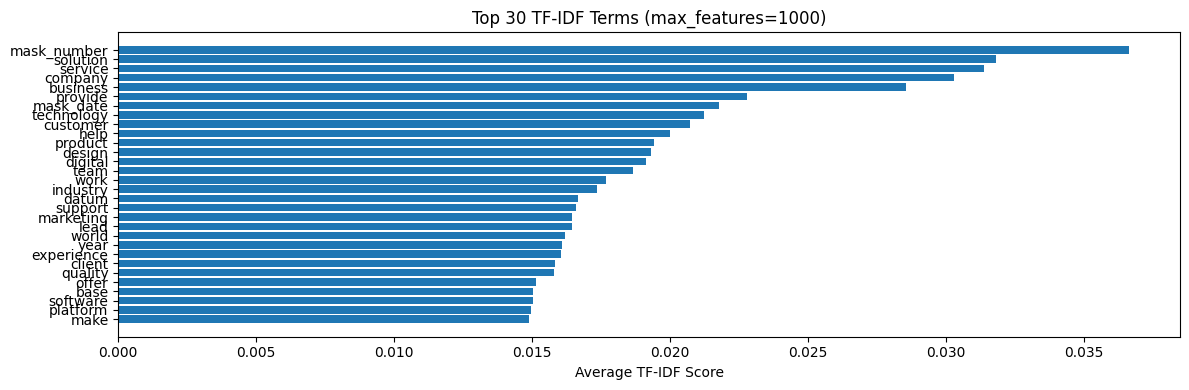

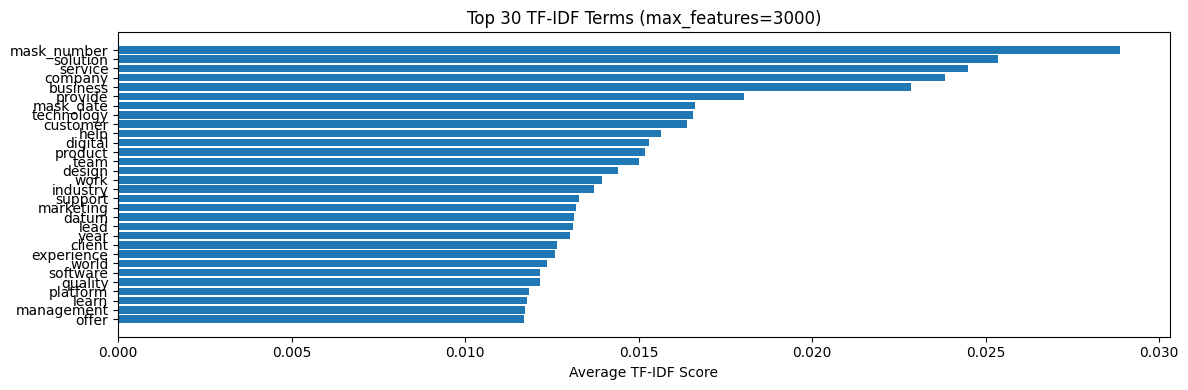

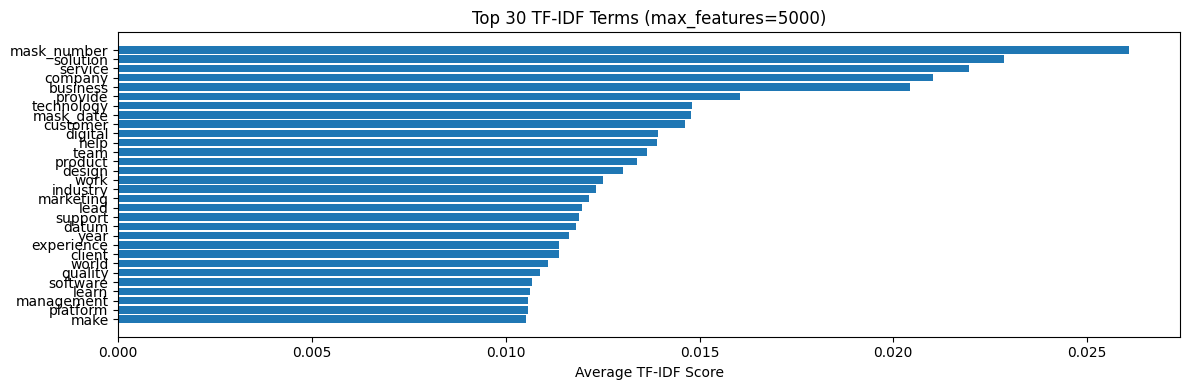

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

for max_feat in [1000, 3000, 5000]:
    tfidf = TfidfVectorizer(max_features=max_feat, stop_words="english", ngram_range=(1, 2))
    tfidf_matrix = tfidf.fit_transform(df["lemmatized_description"])
    terms = tfidf.get_feature_names_out()
    tfidf_means = tfidf_matrix.mean(axis=0).A1
    sorted_indices = tfidf_means.argsort()[::-1]
    
    top_n = 30  # plot top 30 terms
    top_terms = [terms[i] for i in sorted_indices[:top_n]]
    top_scores = [tfidf_means[i] for i in sorted_indices[:top_n]]
    
    plt.figure(figsize=(12, 4))
    plt.barh(top_terms[::-1], top_scores[::-1])
    plt.title(f"Top {top_n} TF-IDF Terms (max_features={max_feat})")
    plt.xlabel("Average TF-IDF Score")
    plt.tight_layout()
    plt.show()

In [22]:
tfidf_0_75k = TfidfVectorizer(max_features=750, stop_words='english', ngram_range=(1, 2)).fit_transform(df["lemmatized_description"])
tfidf_1k = TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1, 2)).fit_transform(df["lemmatized_description"])
tfidf_1_5k = TfidfVectorizer(max_features=1500, stop_words='english', ngram_range=(1, 2)).fit_transform(df["lemmatized_description"])

In [23]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

kmeans_0_75k = KMeans(n_clusters=10, random_state=42).fit(tfidf_0_75k)
kmeans_1k = KMeans(n_clusters=10, random_state=42).fit(tfidf_1k)
kmeans_1_5k = KMeans(n_clusters=10, random_state=42).fit(tfidf_1_5k)

print("Comparing 750 features with 1000 features:")
ari = adjusted_rand_score(kmeans_0_75k.labels_, kmeans_1k.labels_)
nmi = normalized_mutual_info_score(kmeans_0_75k.labels_, kmeans_1k.labels_)
print(f"Adjusted Rand Index: {ari:.4f}")
print(f"Normalized Mutual Information: {nmi:.4f}")

print("Comparing 1000 features with 1500 features:")
ari = adjusted_rand_score(kmeans_1k.labels_, kmeans_1_5k.labels_)
nmi = normalized_mutual_info_score(kmeans_1k.labels_, kmeans_1_5k.labels_)
print(f"Adjusted Rand Index: {ari:.4f}")
print(f"Normalized Mutual Information: {nmi:.4f}")

Comparing 750 features with 1000 features:
Adjusted Rand Index: 0.2374
Normalized Mutual Information: 0.3479
Comparing 1000 features with 1500 features:
Adjusted Rand Index: 0.2795
Normalized Mutual Information: 0.4120


Some rough conclusions:
- The clustering is pretty fragile - clustering with embeddings that capture semantic meaning will be better
- Over 1000 features is probably not needed so we keep it lower for interpretability
- mask_number might be picking up too much (or the other similar ones like money, percent etc aren't working correctly) - would look into & ideally fix this with more time

In [24]:
import spacy
nlp = spacy.load("en_core_web_sm")

for i in range(5):
    sample = df.sample(1)["cleaned_description"].values[0]
    doc = nlp(sample)

    ents = [(ent.label_, ent.text) for ent in doc.ents]
    print(sample)
    for ent in ents:
        print(ent)
    print("\n")

A national law firm with local values. Liverpool based Solicitors with over 35 years experience in property, personal injury, financial claims and wills & probate.
('ORG', 'Liverpool')
('ORG', 'Solicitors')
('DATE', '35 years')


TerraGo delivers software solutions that are relied on every day by leading smart cities & utilities and defense & intelligence organizations in all 50 US states and over 70 countries around the world. TerraGos field operations applications are being utilized by a global customer base including 8 of the 10 largest US utilities, Exelon, ComEd, Dominion Energy, Chicago, London, Jamaica, Toronto, Glasgow, Minnesota, Rhode Island and Illinois (ComEd). TerraGo's geospatial intelligence products are used by the US DoD, Army, Navy, Air Force, Marines, NGA, CIA and over 20 partner nations.
('DATE', 'every day')
('ORG', 'smart cities & utilities')
('ORG', 'defense & intelligence')
('CARDINAL', '50')
('GPE', 'US')
('CARDINAL', '70')
('ORG', 'TerraGos')
('CARDINAL', '8')

Thinking that just ORG, MONEY, DATE and GPE will be most relevant and consistently useful in the context of company blurbs, and keeps it not overly-complicated

In [25]:
from keybert import KeyBERT
from sentence_transformers import SentenceTransformer

bert_model = SentenceTransformer("all-MiniLM-L6-v2")
kw_model = KeyBERT(model=bert_model)

In [26]:
for i in range(5):
    sample = df.sample(1)
    lemmatized_desc = sample["lemmatized_description"].values[0]
    original_desc = sample["company_description"].values[0]
    kws = kw_model.extract_keywords(lemmatized_desc, keyphrase_ngram_range=(1, 2), stop_words='english', top_n=5)
    print(original_desc)
    print(lemmatized_desc)
    print([kw[0] for kw in kws])
    print()

Our Story: Our practice has been established for over 20 years and we have earned ourselves an excellent reputation.
our story our practice have be establish for over mask_number year and we have earn ourselves an excellent reputation
['mask_number year', 'establish mask_number', 'mask_number', 'story practice', 'practice establish']

Nicholas Associates Group, is a group of recruitment companies who are specialists in their fields, supporting talent from Apprentice to Boardroom.
nicholas associates group be a group of recruitment company who be specialist in their field support talent from apprentice to boardroom
['nicholas associates', 'associates group', 'recruitment company', 'nicholas', 'associates']

Greene County Bancorp, Inc., is the bank holding company and parent company of The Bank of Greene County.
greene county bancorp inc be the bank hold company and parent company of the bank of greene county
['bank greene', 'county bancorp', 'greene county', 'bancorp bank', 'bank hold']